# Classifiers in Finance

#### by Gustavo Soares

In this notebook you will apply a few things you learned in the [FinanceHub's Python lectures](https://github.com/Finance-Hub/FinanceHubMaterials/tree/master/Python%20Lectures) to create classifiers. Classifiers are used in Finance to tell us when we are facing a bull or a bear market ahead of us.

## Introduction

Nowadays, it is common to split statistical learning problems into one of two categories: **supervised**
or **unsupervised** learning. Supervised learning problems involve as set of variables $X$ that are going to be used to predict some output variable $Y$. In contrast, unsupervised learning describes the situation where we have a set of variables $X$ and we want to learn about their statistical linkages and relationships but there is no associated response variable $Y$. Regressions and classification are **supervised learning** problems while correlation, PCA and clustering analysis are unsupervised learning problems.

###### Regressions and classifiers

Both supervised and unsupervise learning techniques are part of the basic toolkit of anyone interested in quantitative finance. However, for those with a background in econometrics, supervised learning tolls such as the linear regression model and even classification methods like the Probit or Logit are very familiar. In fact, the linear regression model may be the go-to approach when an econometrician is interested in predicting a response real-valued variable Y.

However, in many situations in Finance, we may be more intesterested in a qualitative response. It is easy to understand why. Let's think about a few scenarios in which we are trying to predict returns:

1. We predict returns to be 5% but they realize 3%;
2. We predict returns to be 5% but they realize 7%;
3. We predict returns to be 1% but they realize -1%;
4. We predict returns to be -4% but they realize -2%, and;
5. We predict returns to be -4% but they realize -6%

If we use the ordinary least squares (OLS) estimator and the standard linear regression model, we would think the five cases above have the same error in absolute terms, 2%. It's true that we can still use other estimators such as weighted least squares in the linear regression model where we could weigh the five scenarios differently. There is a simpler approach, just worry about the sign of the turns. That is, we would consider 1, 2, 4, and 5 good predictions but not 3.


###### Why use classifiers instead of regressions?

Predicting financial returns themselves, as the standard linear regression model attempts to do, is a hard thing to do in Finance. In fact, it is very common to not find any statistically significant conditional mean dependence in asset returns. However, predicting asset return signs is much easier. [Christoffersen and Diebold (2003)](https://www.nber.org/papers/w10009) explain that one of the reasons for that to be the case is that volatility is easily predictable and predictability in volatility produces predictability in the sign of asset returns even when there is no predictability on the returns themselves. This seems a little strange but little or no conditional mean dependence is entirely consistent with a significant degree of sign and volatility predictability.

The other advantage of using signs is that it is a non-parametric or “distribution free”. It is true that estimators of the standard linear regression model are still consistent even when error are not Gaussian. However, in small samples diviations from normality can be very demaging to predictions of the standard linear model when a particular distribution, like the normal distribution, is assumed. This is a very old trick in statatics. For example the [sign test](https://en.wikipedia.org/wiki/Sign_test#Relationship_to_other_statistical_tests) is a non-parametric alternative to the standard t-test.

However, the main rason why we convert the problem of predicting real-valued variable Y in the problem of predicting the sign of Y is so we can use the modern language of [classifiers](https://en.wikipedia.org/wiki/Statistical_classification) to talk about forecasting future bull and bear markets.

Let's start with some basic imports:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm

## Getting the signal data

Here we will use the example of FX trading to illustrate how classifiers work and contrast the results with standard linear regressions. We have discussed previously the three main types of signals in FX trading:
[carry](https://github.com/Finance-Hub/FinanceHubMaterials/blob/master/Quantitative%20Finance%20Lectures/carry.ipynb), [momentum](https://github.com/Finance-Hub/FinanceHubMaterials/blob/master/Quantitative%20Finance%20Lectures/time_series_momentum.ipynb) and [value](https://github.com/Finance-Hub/FinanceHubMaterials/blob/master/Quantitative%20Finance%20Lectures/ppp_value_in_fx.ipynb). So, let's start by getting the data on these three types of signals.

For each signal $s$ for $s \in \{carry,momentum,value\}$ we have a value $x_{s,i,t}$ containing the signal $s$ for currency $i$ at time $t$ already appropriately lagged. Remember, that we need to make sure $x_{s,i,t}$ is only using information that was available at the time of trading to predict h-period returns from time $t$ to some time in the future $t+h$. So, the value $x_{s,i,t}$ needs to be calculated using information prior to $t$. Here, we lag the information set by one period and calculate $x_{s,i,t}$ only with information contained in $\mathscr{I}_{t-1}$.

In [2]:
carry_df = pd.read_excel(r'fx_trackers_and_signals.xlsx',sheetname='carry',index_col=0)
print('carry data has %s currencies and %s dates' % (carry_df.shape[1],carry_df.shape[0]))
mom_df = pd.read_excel(r'fx_trackers_and_signals.xlsx',sheetname='momentum',index_col=0)
print('momentum data has %s currencies and %s dates' % (mom_df.shape[1],mom_df.shape[0]))
value_df = pd.read_excel(r'fx_trackers_and_signals.xlsx',sheetname='value',index_col=0)
print('value data has %s currencies and %s dates' % (value_df.shape[1],value_df.shape[0]))

C:\ProgramData\Anaconda3\lib\site-packages\pandas\util\_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


carry data has 24 currencies and 4973 dates
momentum data has 24 currencies and 4968 dates
value data has 24 currencies and 4973 dates


## Getting the returns data

We also discussed how to construct [FX trackers](https://github.com/Finance-Hub/FinanceHubMaterials/blob/master/Quantitative%20Finance%20Lectures/creating_fx_time_series_fh.ipynb) for each currency against the USD. Here, we will just upload the data on the FX trackers.

In [3]:
trackers_df = pd.read_excel(r'fx_trackers_and_signals.xlsx',sheetname='trackers',index_col=0)
print('trackers data has %s currencies and %s dates' % (trackers_df.shape[1],trackers_df.shape[0]))

trackers data has 24 currencies and 5220 dates


The variable we want to predict is
$$
r_{i,t+h} \equiv \frac{I_{t+h}}{I_{t}}-1
$$

which contains the returns of currency $i$ over the period between $t$ and $t+h$ as measured by the percentage change in the the currency tracker level $I_{t}$ over the period. This assumes that we traded at level $I_{t}$ at inception and closed the position $I_{t+h}$. Let's use `Pandas` to create a dataframe containing these returns for $h=21$ business days:

In [4]:
h = 21
# note the use of the .shift(-h) method below to make sure that on the index t we have the returns from t to t+h
returns_df = trackers_df.pct_change(h).shift(-h).dropna()
print('returns data has %s currencies and %s dates' % (returns_df.shape[1],returns_df.shape[0]))

returns data has 24 currencies and 2241 dates


## Fama-MacBeth regressions

Now, that we have the future returns data. Let's start with some old-fashioned regressions to see if our signals can be used to predict future returns. That is, let's start with a model of the type: 
$$
r_{i,t+h} = \gamma + \beta´X_{i,t} + \eta_{i,t+h}
$$

where $X_{i,t} = [x_{carry,i,t},x_{momentum,i,t},x_{value,i,t}]'$ is a $3 \times 1$ vector of signals containing the signals for currency $i$ at time $t$. This vector $X_{i,t}$ will be used to predict the future returns $r_{i,t+h}$.

These types of regressions of future returns on features or characteristics are often called [Fama-MacBeth](https://en.wikipedia.org/wiki/Fama%E2%80%93MacBeth_regression) regressions. See also [Cochrane's summary](https://faculty.chicagobooth.edu/john.cochrane/teaching/coursera_documents/Classic_regressions_summary.pdf) and [Cochrane's video lecture](https://www.youtube.com/watch?v=lkFon5Jhw-A&list=PLAXSVuGaw0KxVUym8IRkObSbUPEFaSbPt&index=15&t=0s).

In [5]:
pooled_data = pd.DataFrame()
for ccy in returns_df.columns:
    # get future returns
    y = returns_df[ccy].to_frame('returns')
    # get the three signals
    X_carry = carry_df[ccy].dropna().to_frame('carry')
    X_mom = mom_df[ccy].dropna().to_frame('mom')
    X_value = value_df[ccy].dropna().to_frame('value')
    # make sure the signals are lined up and fill the nan's with the last obs in case there are some
    X = pd.concat([X_carry,X_mom,X_value],join='outer',axis=1,sort=True).fillna(method='ffill').dropna()
    # add constant to regression
    X = sm.add_constant(X)
    # make sure the dates of the signals and future returns line up
    yX = pd.concat([y,X],axis=1,sort=True).dropna()
    pooled_data = pooled_data.append(yX)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Now that we have the pooled data, let's run OLS:

In [6]:
model = sm.OLS(pooled_data.iloc[:,0], pooled_data.iloc[:,1:]).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     51.04
Date:                Sun, 29 Mar 2020   Prob (F-statistic):           6.25e-33
Time:                        12:16:52   Log-Likelihood:             1.0991e+05
No. Observations:               53532   AIC:                        -2.198e+05
Df Residuals:                   53528   BIC:                        -2.198e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0031      0.000    -18.121      0.0

It's interesting to see that all parameters seem to be statistically significant. That said, it's a little strange that the momentum metric came out with a negative sign. Let's try using the sign in the right hand side, i.e., let's try using the regression:

$$
sign(r_{i,t+h}) = \gamma + \beta´X_{i,t} + \eta_{i,t+h}
$$

to see if anything comes out:

In [7]:
model = sm.OLS(np.sign(pooled_data.iloc[:,0]), pooled_data.iloc[:,1:]).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     100.2
Date:                Sun, 29 Mar 2020   Prob (F-statistic):           1.11e-64
Time:                        12:16:52   Log-Likelihood:                -75797.
No. Observations:               53532   AIC:                         1.516e+05
Df Residuals:                   53528   BIC:                         1.516e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0750      0.006    -13.607      0.0

Much better!! All parameters seem to be statistically significant and now the three metrics contribute positively to returns. We want to get long currencies that have high carry, positive momentum and are cheap! Makes sense ...

Let's try some interactions just to see what happens:

In [8]:
from sklearn.preprocessing import PolynomialFeatures
X_with_interactions = PolynomialFeatures(interaction_only=True)
X_with_interactions.fit_transform(pooled_data.iloc[:,2:])
features = X_with_interactions.get_feature_names(pooled_data.columns[2:])
features[0] = 'const'
X_with_interactions = X_with_interactions.fit_transform(pooled_data.iloc[:,2:])
X_with_interactions = pd.DataFrame(index=pooled_data.index,data=X_with_interactions,columns=features)
model = sm.OLS(np.sign(pooled_data.iloc[:,0]),X_with_interactions).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     50.78
Date:                Sun, 29 Mar 2020   Prob (F-statistic):           1.23e-62
Time:                        12:16:53   Log-Likelihood:                -75795.
No. Observations:               53532   AIC:                         1.516e+05
Df Residuals:                   53525   BIC:                         1.517e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0756      0.006    -13.264      

Also, interesting results here. We can see all three metrics are good contributer but momentum is particularly interesting when associated with carry as opposed to a stand alone signal.

###### Time series regressions

One of the problems with the regressions above is that we do not know if $X_{i,t+1}$ is statistically significant because it helps us predict time series returns or cross-sectional returns. Let's think about time series regressions of the type:

$$
sign(r_{i,t+h}) = \gamma_{i} + \beta_{i}´X_{i,t} + \eta_{i,t+h}
$$

In time series regressions we estimate a sequence of scalar estimates $\hat{\gamma}_{1},\dots,\hat{\gamma}_{N}$ and the columns ['carry', 'mom', 'value'] containing the sequence of $3 \times 1$ beta vectors $\hat{\beta}_{1},\dots,\hat{\beta}_{N}$. In our case, $N=24$.

In [9]:
reg_params = pd.DataFrame()
for ccy in returns_df.columns:
    # get future returns
    y = returns_df[[ccy]]
    # get the three signals
    X_carry = carry_df[ccy].dropna().to_frame('carry')
    X_mom = mom_df[ccy].dropna().to_frame('mom')
    X_value = value_df[ccy].dropna().to_frame('value')
    # make sure the signals are lined up and fill the nan's with the last obs in case there are some
    X = pd.concat([X_carry,X_mom,X_value],join='outer',axis=1,sort=True).fillna(method='ffill').dropna()
    # add constant to regression
    X = sm.add_constant(X)
    # make sure the dates of the signals and future returns line up
    yX = pd.concat([y,X],axis=1,sort=True).dropna()
    # fit the model using OLS
    model = sm.OLS(np.sign(yX.iloc[:,0]), yX.iloc[:,1:]).fit()
    # save the results in the reg_params dataframe
    reg_params = reg_params.append((model.tvalues).to_frame(ccy).T)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


After running the code above, we have a dataframe with each currency $i$ in the index and a column "const" containing a sequence of scalar estimates $\hat{\gamma}_{1},\dots,\hat{\gamma}_{N}$ and the columns ['carry', 'mom', 'value'] containing the sequence of $3 \times 1$ beta vectors $\hat{\beta}_{1},\dots,\hat{\beta}_{N}$. See also [Cochrane's summary](https://faculty.chicagobooth.edu/john.cochrane/teaching/coursera_documents/Classic_regressions_summary.pdf) and [Cochrane's video lecture](https://www.youtube.com/watch?v=lkFon5Jhw-A&list=PLAXSVuGaw0KxVUym8IRkObSbUPEFaSbPt&index=15&t=0s).

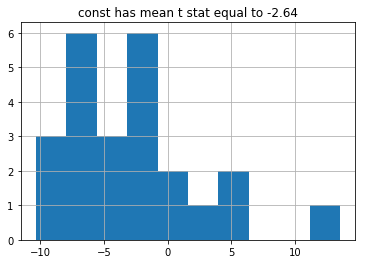

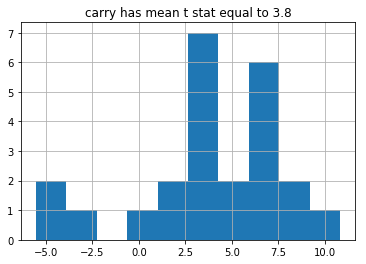

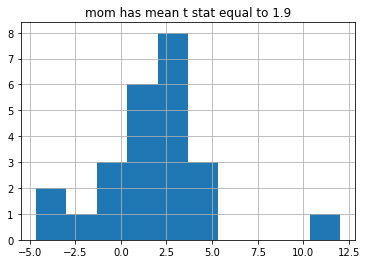

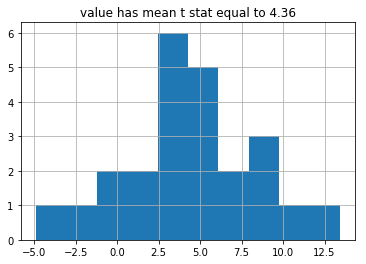

In [10]:
for feature in reg_params.columns:
    reg_params[feature].hist()
    plt.title('%s has mean t stat equal to %s' % (feature,np.round(reg_params[feature].mean(),2)))
    plt.show()

We are getting interesting time series results here, particularly for carry and value. Momentum seems to be a bit split. Perhaps, dividing the currencies in two groups G10 and EM would help. We will leave that as an exercise below.

###### Rolling regressions

We can use the regressions above for some preliminary analysis but we cannot use them in our backtest why the estimation of the parameters $\hat{\gamma}_{1},\dots,\hat{\gamma}_{N}$ and $\hat{\beta}_{1},\dots,\hat{\beta}_{N}$ use information from the full sample. Hence, we cannot backtest trading descisions in the past using those estimates since it would contain information not available at the time. We need to use rolling regressions. Let's pick one currency, say the BRL, to illustrate:

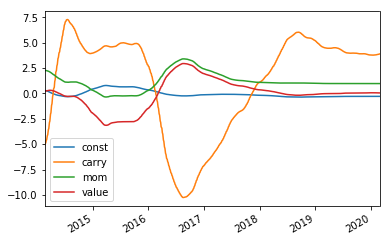

In [11]:
rolling_betas = pd.DataFrame()
ccy = 'BRL'
y = np.sign(returns_df[[ccy]].dropna())
X_carry = carry_df[ccy].dropna().to_frame('carry')
X_mom = mom_df[ccy].dropna().to_frame('mom')
X_value = value_df[ccy].dropna().to_frame('value')
# make sure the signals are lined up and fill the nan's with the last obs in case there are some
X = pd.concat([X_carry,X_mom,X_value],join='outer',axis=1,sort=True).fillna(method='ffill').dropna()
# add constant to regression
X = sm.add_constant(X)
yX = pd.concat([y,X],axis=1,sort=True).shift(1).dropna() # adding an extra day lag to be safe
for d in y.index[3*252:]:
    past_returns = yX.iloc[:,0].loc[:d].ewm(halflife=60).mean() # adding an extra smoothing with EWMA
    past_features = yX.iloc[:,1:].loc[:d].ewm(halflife=60).mean() 
    XX = np.linalg.inv(np.dot(past_features.T,past_features))
    ols_beta = np.dot(XX,np.dot(past_features.T,past_returns))
    ols_beta = pd.DataFrame(columns=[d],index=yX.columns[1:],data=ols_beta)
    rolling_betas = rolling_betas.append(ols_beta.T)

rolling_betas.plot()

## Logistic regressions

Now that we are modeling the sign of the returns instead of the returns themselves. Let's take a look at the classification techniques discussed in Chapter 4 of [James, Witten, Hastie, and Tibshirani (2013)](http://faculty.marshall.usc.edu/gareth-james/ISL/), starting with logistic regressions.

In the logistic regression model we have:
$$
Prob(r_{i,t+h} \geqslant 0 | X_{i,t}) = \frac{e^{\gamma_{i} + \beta_{i}´X_{i,t}}}{1+e^{\gamma_{i} + \beta_{i}´X_{i,t}}}
$$

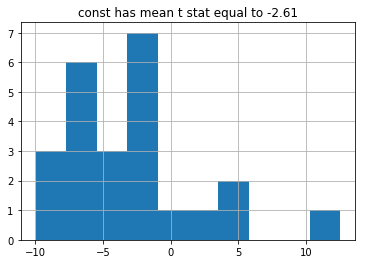

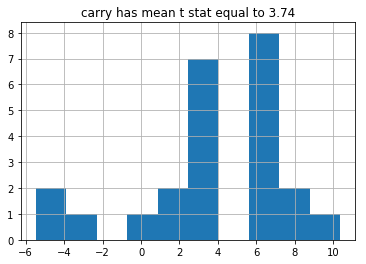

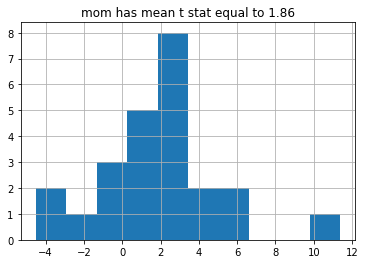

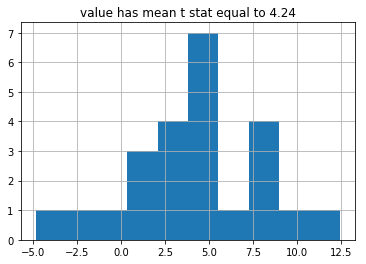

In [12]:
reg_params = pd.DataFrame()
for ccy in returns_df.columns:
    # get future returns
    y = returns_df[[ccy]]
    # get the three signals
    X_carry = carry_df[ccy].dropna().to_frame('carry')
    X_mom = mom_df[ccy].dropna().to_frame('mom')
    X_value = value_df[ccy].dropna().to_frame('value')
    # make sure the signals are lined up and fill the nan's with the last obs in case there are some
    X = pd.concat([X_carry,X_mom,X_value],join='outer',axis=1,sort=True).fillna(method='ffill').dropna()
    # add constant to regression
    X = sm.add_constant(X)
    # make sure the dates of the signals and future returns line up
    yX = pd.concat([y,X],axis=1,sort=True).dropna()
    # fit the model using Logit
    model = sm.Logit(1*(yX.iloc[:,0]>=0), yX.iloc[:,1:]).fit(disp=False)
    # save the results in the reg_params dataframe
    reg_params = reg_params.append((model.tvalues).to_frame(ccy).T)

for feature in reg_params.columns:
    reg_params[feature].hist()
    plt.title('%s has mean t stat equal to %s' % (feature,np.round(reg_params[feature].mean(),2)))
    plt.show()

The results here are very similar to the ones in the linear regression where carry and value statistically increase the probability of the currency going up while momentum a little bit less so. 

###### Making predictions

Again, we can use these regressions above for some preliminary analysis but we cannot use them in our backtest because the estimation of the parameters uses information from the full sample. Hence, we cannot backtest trading descisions in the past using those estimates since it would contain information not available at the time. We need to use rolling regressions. Let's pick one currency, say the BRL, to illustrate:

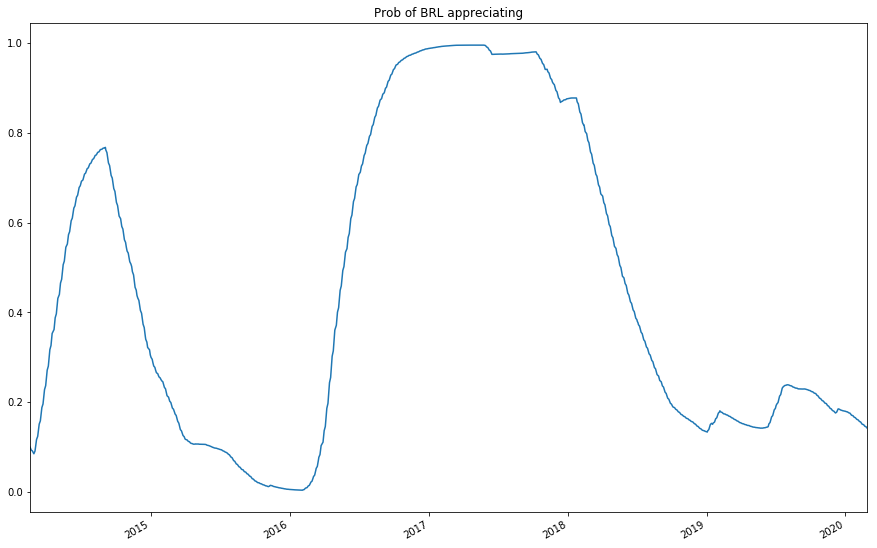

In [13]:
prob_market_going_up = pd.Series()
ccy = 'BRL'
y = np.sign(returns_df[[ccy]].dropna())
X_carry = carry_df[ccy].dropna().to_frame('carry')
X_mom = mom_df[ccy].dropna().to_frame('mom')
X_value = value_df[ccy].dropna().to_frame('value')
# make sure the signals are lined up and fill the nan's with the last obs in case there are some
X = pd.concat([X_carry,X_mom,X_value],join='outer',axis=1,sort=True).fillna(method='ffill').dropna()
# add constant to regression
X = sm.add_constant(X)
yX = pd.concat([y,X],axis=1,sort=True).shift(1).dropna() # adding an extra day lag to be safe
for d in y.index[3*252:]:
    past_returns = yX.iloc[:,0].loc[:d].ewm(halflife=60).mean() # adding an extra smoothing with EWMA
    past_features = yX.iloc[:,1:].loc[:d].ewm(halflife=60).mean()     
    
    # fit the model using Logit
    model = sm.Logit(1*(past_returns>=0), past_features).fit(disp=False)
    
    # use current features to predict the market 
    prob_market_going_up[d]= model.predict()[-1] 
    
prob_market_going_up.plot(title='Prob of %s appreciating' % ccy,figsize=(15,10))

## Linear Discriminant Analysis

Linear Discriminant Analysis (LDA) is a type of classifier with a linear decision boundary, generated by fitting class conditional densities to the data and using Bayes’ rule. Its approach is different from regressions as LDA models the distribution of the signals $X_{i,t}$ separately in each of the response classes (i.e. future $sign(r_{i,t+h})$), and then use Bayes’ theorem to flip these around into estimates for $Prob(r_{i,t+h} \geqslant 0 | X_{i,t})$. It is common for the parameters of the logistic regression model to be somewhat unstable and LDA does not suffer from this problem so much, this is particularly true in small samples. Let's pick one currency, say the BRL, to illustrate.

In [14]:
ccy = 'BRL'
y = 1*(np.sign(returns_df[[ccy]].dropna())>=0)

X_carry = carry_df[ccy].dropna().to_frame('carry')
X_mom = mom_df[ccy].dropna().to_frame('mom')
X_value = value_df[ccy].dropna().to_frame('value')

# make sure the signals are lined up and fill the nan's with the last obs in case there are some
X = pd.concat([X_carry,X_mom, X_value],join='outer',axis=1,sort=True).shift(1).fillna(method='ffill').dropna()
X_with_interactions = PolynomialFeatures(interaction_only=True)
X_with_interactions.fit_transform(X)
features = X_with_interactions.get_feature_names(X.columns)
features[0] = 'const'
X_with_interactions = X_with_interactions.fit_transform(X)
X_with_interactions = pd.DataFrame(index=X.index,data=X_with_interactions,columns=features).drop('const',1)
X_with_interactions.tail()

,carry,mom,value,carry mom,carry value,mom value
2020-03-23,0.017339,-0.252130,0.907634,-0.004372,0.015737,-0.228842
2020-03-24,0.015030,-0.270541,0.926471,-0.004066,0.013925,-0.250648
2020-03-25,0.016688,-0.263456,0.918082,-0.004397,0.015321,-0.241874
2020-03-26,0.019164,-0.270274,0.917885,-0.005180,0.017591,-0.248081
2020-03-27,0.018690,-0.263019,0.905344,-0.004916,0.016921,-0.238122


In [15]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis()
yX = pd.concat([y,X_with_interactions],axis=1,sort=True).shift(1).dropna() # adding an extra day lag to be safe
clf.fit(yX.iloc[:,1:], yX.iloc[:,0])
current_market_features = X_with_interactions.iloc[-1].values
prediction = 'bull' if clf.predict([current_market_features])[0]>0 else 'bear'
print('LDA is predicting a %s market' % prediction)

LDA is predicting a bull market


## k-Nearest-Neighbor (KNN)

K-nearest neighbors (KNN) classifiers are discussed in Chapter 2 of [James, Witten, Hastie, and Tibshirani (2013)](http://faculty.marshall.usc.edu/gareth-james/ISL/). KNN classifiers are *memory based* classifiers. They will look in the past data and find other times where the features lined up more or less similarly to the way they line up now and then they will make a prediction on whether the market is going to go up or down based on what happened in those prior similar dates. Let's pick one currency, say the BRL, to illustrate.

In [16]:
ccy = 'BRL'
y = 1*(np.sign(returns_df[[ccy]].dropna())>=0)
X_carry = carry_df[ccy].dropna().to_frame('carry')
X_value = value_df[ccy].dropna().to_frame('value')
# make sure the signals are lined up and fill the nan's with the last obs in case there are some
X = pd.concat([X_carry,X_value],join='outer',axis=1,sort=True).fillna(method='ffill').dropna()
yX = pd.concat([y,X],axis=1,sort=True).shift(1).dropna() # adding an extra day lag to be safe

Just to help visualize things let's plot the times when the market went up/down in blue/red and see what the carry and value signals were for the BRL

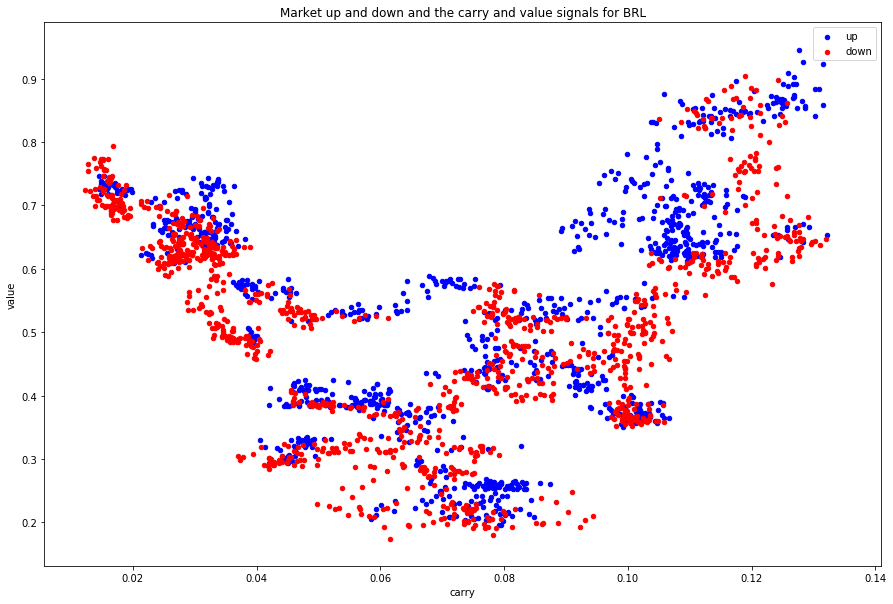

In [17]:
# Visualising the features
plt.figure(figsize=(15,10))
plot_df = yX[yX.iloc[:,0] == 1]
plt.scatter(plot_df.iloc[:,1], plot_df.iloc[:,2], s = 20, c = 'blue', label = 'up')
plot_df = yX[yX.iloc[:,0] == 0]
plt.scatter(plot_df.iloc[:,1], plot_df.iloc[:,2], s = 20, c = 'red', label = 'down')
plt.legend()
plt.xlabel(plot_df.columns[1])
plt.ylabel(plot_df.columns[2])
plt.title('Market up and down and the carry and value signals for %s' % ccy)
plt.show()

Like anything in Finance, the picture is not super clear but I think we can make the case that high carry and high value dates have been followed more by up markets (blue dots) than down markets (red dots). Let's look at the medians for each groups to convince ourselves:

In [18]:
sum_df = yX.groupby(yX.columns[0]).median()
sum_df.index = ['down','up']
sum_df

,carry,value
down,0.067072,0.516884
up,0.077455,0.545413


Indeed, the median of the carry and value metrics are slighly lower when what follows is down market than when what follows is an up market.

Now, let's put back momentum into the mix and look also and the interactions of three features:

In [19]:
X_carry = carry_df[ccy].dropna().to_frame('carry')
X_mom = mom_df[ccy].dropna().to_frame('mom')
X_value = value_df[ccy].dropna().to_frame('value')

# make sure the signals are lined up and fill the nan's with the last obs in case there are some
X = pd.concat([X_carry,X_mom, X_value],join='outer',axis=1,sort=True).shift(1).fillna(method='ffill').dropna()
X_with_interactions = PolynomialFeatures(interaction_only=True)
X_with_interactions.fit_transform(X)
features = X_with_interactions.get_feature_names(X.columns)
features[0] = 'const'
X_with_interactions = X_with_interactions.fit_transform(X)
X_with_interactions = pd.DataFrame(index=X.index,data=X_with_interactions,columns=features).drop('const',1)
X_with_interactions.tail()

,carry,mom,value,carry mom,carry value,mom value
2020-03-23,0.017339,-0.252130,0.907634,-0.004372,0.015737,-0.228842
2020-03-24,0.015030,-0.270541,0.926471,-0.004066,0.013925,-0.250648
2020-03-25,0.016688,-0.263456,0.918082,-0.004397,0.015321,-0.241874
2020-03-26,0.019164,-0.270274,0.917885,-0.005180,0.017591,-0.248081
2020-03-27,0.018690,-0.263019,0.905344,-0.004916,0.016921,-0.238122


The first step in the KNN classifier is to find K dates, the *K-neighbors* that have signals closest to the current signals $X_{i,t}$. Let's represent that set of past dates as $\mathscr{N}_{K,t-1}$ where the subscript ${K,t-1}$ indicates that it is the set contains $K$ points and it only uses data up until $t-1$. Now, let's use [sklearn.neighbors.KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) to classify past dates in 5 different groups:

In [20]:
from sklearn.neighbors import KNeighborsClassifier
yX = pd.concat([y,X_with_interactions],axis=1,sort=True).dropna()
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(yX.iloc[:,1:], yX.iloc[:,0])
current_market_features = X_with_interactions.iloc[-1].values
prediction = 'bull' if neigh.predict([current_market_features])[0]>0 else 'bear'
prob_0_and_1 = neigh.predict_proba([current_market_features])[0]
probability = prob_0_and_1[0] if prediction == 'bear' else prob_0_and_1[1]
print('KNN is predicting a %s market with prob %s pct' % (prediction,100*probability))

KNN is predicting a bear market with prob 80.0 pct


## Support Vector Classifiers

Support vector classifiers (SVC) is a popular technique for classification. SVCs have been shown to perform well in a variety of settings, and are often considered one of the best “out of the box” classifiers. SVC performs particularly well relative to other methods when we have high dimensional spaces. SVCs do not directly provide probability estimates, these are calculated using an expensive five-fold cross-validation. A good discusion on SVM can be found in Chapter 9 of [James, Witten, Hastie, and Tibshirani (2013)](http://faculty.marshall.usc.edu/gareth-james/ISL/).  Let's use the [support vector machines package in scikit-learn](https://scikit-learn.org/stable/modules/svm.html#svm-classification) to carry out the SVC predictions:

In [21]:
from sklearn import svm
clf = svm.SVC()

# Let's fit the model to predict the sign of the future market
clf.fit(yX.iloc[:,1:], yX.iloc[:,0])

# take the current value of the features
prediction = 'bull' if clf.predict([current_market_features])[0]>0 else 'bear'
print('SVM is predicting a %s market' % prediction)

SVM is predicting a bull market


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


## Exercises

#### Beginners

Try to calculate the regressions we calculated here but running separate regressions for G10 and EM currencies. See if there is a difference in estimates that may justify implemeting a quantitative investment strategy differently for the two groups.

#### Intermediate

Using one or more of the techniques discussed above, create a function that takes inputs some data on past returns and signals and makes a prediction on whether the market is going to go up or down. Give the user several options.

#### Intermediate

Compare the different models predictions in terms of:

$$
ER \text{ (Error rate)}=  (FN+FP) / (TP+FP+FN+TN) \\
Accuracy = (TP+TN)/(TP+FP+FN+TN) \\
Precision = TP/(TP+FP) \\
Recall = TP/(TP+FN) \\
Specificity = TN/(TN+FP) \\
FAR \text{ (False alarm rate)} = 1-Specificity = FP/(TN+FP) \\
F-measure = \frac{2 \times Recall \times Precision}{Recall + Precision}
$$

where

* $TP$ is the number of *true positives*, i.e., the number of times the signal predicted positive returns and it was right;
* $TN$ is the number of *true negatives*, i.e., the number of times the signal predicted negative returns and it was right;
* $FP$ is the number of *false positives* (Type 1 Error), i.e., the number of times the signal predicted positive returns and it was wrong, and
* $FN$ is the number of *false negatives* (Type 2 Error), i.e., the number of times the signal predicted negative returns and it was wrong.

#### Advanced

In Machine Learning, the AUC (Area Under The Curve) ROC (Receiver Operating Characteristics) curve is often used to asses performance of classifiers. The AUCROC curve is one of the most important evaluation metrics for checking any classification model’s performance and it consists of a chart of the **Recall** (True Positive Rate), $TP/(TP+FN)$, in the y-axis and the **False alarm rate** (False Positive Rate), $FP/(TN+FP)$ in the x-axis. The higher the AUC, better the model is at predicting bear markets as bear markets (0s) and bull markets as bull markets (1s).

First, create a [confusion matrix](https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62) using the metrics $TP,FP,FN,TN$ defined above and then create a [AUCROC curve](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5) for methods we discussed here. 

#### Jedi Master

Carry out the Advanced task above and make a contribution to [FinanceHub's signals class](https://github.com/Finance-Hub/FinanceHub/tree/master/signals) by creating a class that measures performance of classifiers.